In [1]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.linear_model import LogisticRegression


In [2]:
#build toy dataset
def generate_samples_gauss(n_samples_class):
    cov = np.array([[10, 2], [2, 1]])
    mean1 = np.array([0, 0])
    mean2 = np.array([0, 5])

    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 2))

    x[:n_samples_class, 0], x[:n_samples_class, 1] = np.random.multivariate_normal(mean1, cov, n_samples_class).T
    x[n_samples_class:, 0], x[n_samples_class:, 1]  = np.random.multivariate_normal(mean2, cov, n_samples_class).T

    labels = np.zeros(total_n_samples)
    labels[n_samples_class:] = 1
    return x, labels

In [3]:
def generate_samples_uniform(n_samples_class):
    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 2))    
    x[:,0] = np.random.rand(2*n_samples_class)
    x[n_samples_class:,1] = x[n_samples_class:,0] + 0.1
    x[:n_samples_class,1] = x[:n_samples_class,0] - 0.1
    
    labels = np.zeros(2*n_samples_class)
    labels[n_samples_class:] = 1
    return x, labels

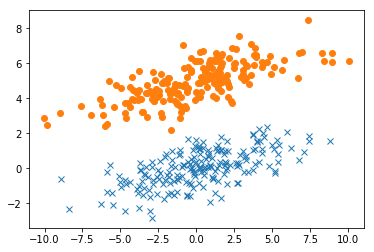

In [4]:
n_samples_class = 200
x, y  =  generate_samples_gauss(n_samples_class)
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')

#plt.savefig("data_2d.png")
plt.show()

In [5]:
latent_dim = 1 #suppose z is scalar
x_dim = 2      
size_f = latent_dim*x_dim

params_size_logit_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim + 1
params_size_norm_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim
params_size_logit_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim + 1
params_size_norm_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim 

In [6]:
opt = "ppca"

if (opt == "fa"):
    params_size = params_size_logit_fa
else:
    params_size = params_size_logit_ppca
    


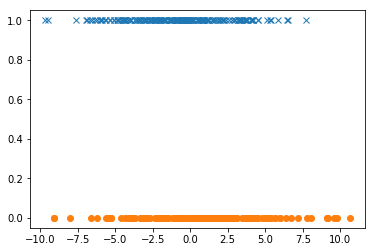

In [7]:
transformer = PCA(n_components=latent_dim)
#transformer = FactorAnalysis(n_components=1, random_state=0)
x_proj_fa_python = transformer.fit_transform(x)
f_fa_python = transformer.components_
plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.savefig('data_proj_fa_python')
plt.show()

In [210]:
f_sklearn = transformer.components_.T
cov_noise_sklearn = np.diag(np.ones(x_dim)*transformer.noise_variance_)
bias_sklearn = np.mean(x, axis =0)

def compute_ll(f,bias,cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2
    ll += log_det_cov_x*N/2
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    return -ll

def compute_pl_logit(f, bias_x, cov_noise, w, x, y):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))

    return np.sum(log_bern_pdf_y)

compute_ll(f_sklearn, bias_sklearn, cov_noise_sklearn, x)

-2022.6357047514343

In [9]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior
    return ll 


def objective_norm (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    sigma = 1 # variance for the noise in y
    N = x.shape[0]
    D = x.shape[1]
    f, bias, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.einsum("dl,dm->lm", f, np.linalg.solve(cov_x,f)) #in fact m=l <- latent dimension 
    cov_z = np.identity(latent_dim) - temp1

    var_y = np.dot(w,np.dot(cov_z,w)) + sigma**2
    
    ll = N*D*np.log(2*np.pi)/2+(log_det_cov_x + lambda_e*np.log(var_y))*N*0.5
    
    temp2 = np.linalg.solve(cov_x, (x - bias).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias, temp2)
    mean_z = np.einsum("dl,dn->nl", f, temp2)
    mean_y = np.einsum("l,nl->n", w, mean_z)
    unnorm_log_pdf_y = (y - mean_y)**2/var_y
    ll = ll + 0.5*(np.sum(unnorm_log_pdf_x) + lambda_e*np.sum(unnorm_log_pdf_y))
    
    log_prior = 0 #f,bias,cov_noise and m for regularization use gaussian priors later
    ll = ll - log_prior
    return ll

def decode_parameters(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    #f = f*np.array([0,1]) + np.array([1,0])
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        #cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
        cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise= np.diag(np.log(1+np.exp(var)))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def transform(f, bias, cov_noise, x):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    return mean_z

In [171]:
params = np.random.rand(params_size)
f, bias, cov_noise, w =  decode_parameters(params, x_dim, latent_dim, opt)
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "bias: ", bias
print "cov_noise matrix: ", cov_noise
print "bias for y:\n", w[0]
print "logistic regression weights:\n", w[1:]
print "initial obj value logit", objective_logit(params, x, y, latent_dim, 0, opt)
#print "initial obj value norm", objective_norm(params, x, y, latent_dim, 0, opt)

Initial parameters
F: [[0.70282428]
 [0.23167521]]
slope [0.32963461]
bias:  [0.1589137  0.35641362]
cov_noise matrix:  [[1.11303089 0.        ]
 [0.         1.11303089]]
bias for y:
0.476645781344998
logistic regression weights:
[0.72681027]
initial obj value logit 4201.815613568728


In [184]:
lambda_e = 10
#run minimizer use ADAM instead?
def pcallback(params):
    f, bias, cov_noise, w = decode_parameters(params, x_dim, latent_dim, opt)
    print compute_ll(f, bias, cov_noise, x), f[1]/f[0]

    
grad_objective_logit = grad(objective_logit, argnum = 0)

params_optimizied_logit_2, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_e, opt),  pgtol = 1e-2)
f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
print "Final parameters_logit"
print "logit slope\n", f_logit[1]/f_logit[0]
print "F:\n", f_logit
print "bias for x:\n", bias_logit
print "cov_noise matrix:\n", cov_noise_logit
print "bias for y:\n", w_logit[0]
print "logistic regression weights:\n", w_logit[1:]
print "final objective value:\n", obj_value_logit
dict

Final parameters_logit
logit slope
[-2.98890084]
F:
[[-0.03697875]
 [ 0.11052581]]
bias for x:
[0.05551974 2.47580845]
cov_noise matrix:
[[8.99967741 0.        ]
 [0.         8.99967741]]
bias for y:
-186.76341629094424
logistic regression weights:
[49831.60428071]
final objective value:
2015.4505455489043


{'funcalls': 86,
 'grad': array([ 4.22716064e+00, -7.78209456e+00,  4.66581280e-01, -3.93505337e+00,
         3.06517016e+00,  2.03298719e-03, -6.16974673e-05]),
 'nit': 76,
 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'warnflag': 0}

In [236]:
lambda_e = 0
params_optimizied_logit_1, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_e, opt))
lambda_e = 10
params_optimizied_logit_2, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_e, opt))

lambda_es = np.arange(0,10,1)
obj_values_logit = np.ones((2, lambda_es.shape[0]))

f_logit_1, bias_logit_1, cov_noise_logit_1, w_logit_1 = decode_parameters(params_optimizied_logit_1, x_dim, latent_dim, opt)
ll_1=  compute_ll(f_logit_1, bias_logit_1, cov_noise_logit_1, x)
pl_1 = compute_pl_logit(f_logit_1, bias_logit_1, cov_noise_logit_1, w_logit_1, x, y) 

f_logit_2, bias_logit_2, cov_noise_logit_2, w_logit_2 = decode_parameters(params_optimizied_logit_2, x_dim, latent_dim, opt)
ll_2=  compute_ll(f_logit_2, bias_logit_2, cov_noise_logit_2, x)
pl_2 = compute_pl_logit(f_logit_2, bias_logit_2, cov_noise_logit_2, w_logit_2, x, y) 

for i in range(lambda_es.shape[0]):
    obj_values_logit[0,i] = objective_logit(params_optimizied_logit_1, x, y, latent_dim, lambda_es[i], opt)
    obj_values_logit[1,i] = objective_logit(params_optimizied_logit_2, x, y, latent_dim, lambda_es[i], opt)
 

In [237]:
print ll_1
print pl_1
print ll_2
print pl_2
 

-1994.7126762510902
-275.73434108056705
-2015.4485124198588
-0.00020331290455426266


In [228]:
print "Final parameters_logit"
print "logit slope\n", f_logit_1[1]/f_logit_1[0]
print "F:\n", f_logit_1
print "bias for x:\n", bias_logit_1
print "cov_noise matrix:\n", cov_noise_logit_1
print "bias for y:\n", w_logit_1[0]
print "logistic regression weights:\n", w_logit_1[1:]


Final parameters_logit
logit slope
[0.43155577]
F:
[[2.16328722]
 [0.93357909]]
bias for x:
[0.04679518 2.48860796]
cov_noise matrix:
[[6.23780083 0.        ]
 [0.         6.23780083]]
bias for y:
0.476645781344998
logistic regression weights:
[0.72681027]


In [230]:
print "Final parameters_logit"
print "logit slope\n", f_logit_2[1]/f_logit_2[0]
print "F:\n", f_logit_2
print "bias for x:\n", bias_logit_2
print "cov_noise matrix:\n", cov_noise_logit_2
print "bias for y:\n", w_logit_2[0]
print "logistic regression weights:\n", w_logit_2[1:]

Final parameters_logit
logit slope
[-2.98750481]
F:
[[-0.51733066]
 [ 1.54552784]]
bias for x:
[0.40027842 1.42137974]
cov_noise matrix:
[[8.11740452 0.        ]
 [0.         8.11740452]]
bias for y:
-9641.225773125338
logistic regression weights:
[45324.89856952]


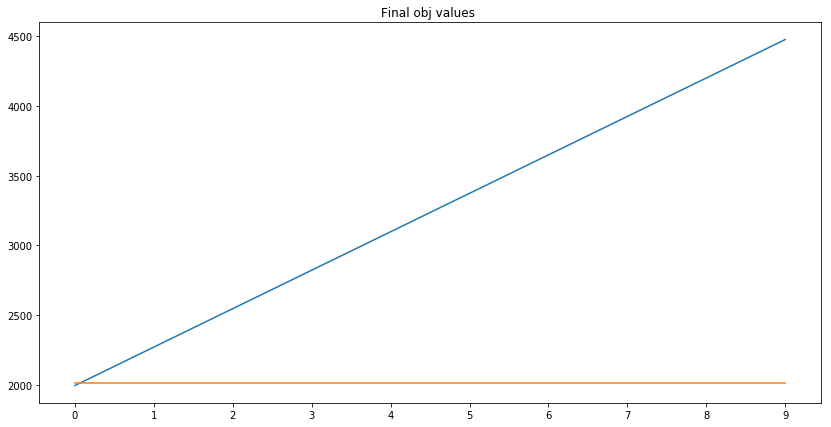

In [239]:
plt.figure(figsize=(14,7))
plt.title("Final obj values ")
plt.xticks(lambda_es)
plt.plot(lambda_es, obj_values_logit[0, :])
plt.plot(lambda_es, obj_values_logit[1, :])


In [13]:
print "F sklearn", f_sklearn 
print "mean of x \n", bias_sklearn 
print "cov noise sklearn\n", cov_noise_sklearn 
#print transformer.loglike_

F sklearn [[0.91814833]
 [0.39623684]]
mean of x 
[0.0467987  2.48861474]
cov noise sklearn
[[6.25345791 0.        ]
 [0.         6.25345791]]


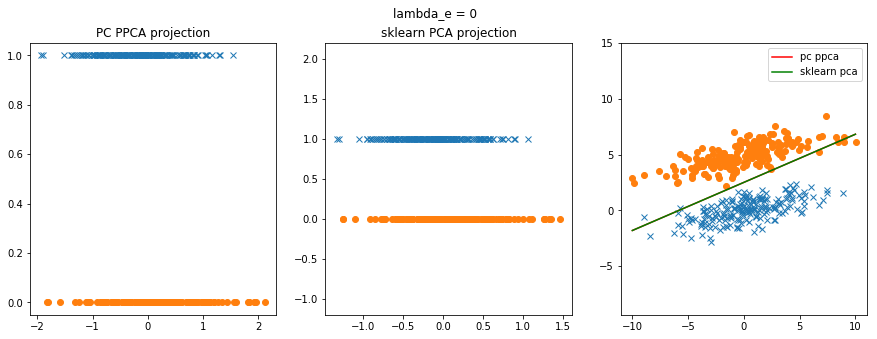

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(131) 
#plt.axis('equal')

plt.suptitle("lambda_e = {}".format(lambda_e))

plt.title("PC PPCA projection")
x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
plt.plot(x_proj_logit[:n_samples_class], np.ones(n_samples_class), 'x')
plt.plot(x_proj_logit[n_samples_class:], np.zeros(n_samples_class), 'o')

plt.subplot(132) 
plt.axis('equal')

plt.title("sklearn PCA projection")
x_proj_sklearn = transform(f_sklearn, bias_sklearn, cov_noise_sklearn, x)

plt.plot(x_proj_sklearn[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_sklearn[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.subplot(133) 
plt.axis('equal')
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')
a_pc_fa_logit = np.array(range(int(round(np.min(x[:,0]))), (1+int(round(np.max(x[:,0])))))) 
a_sklearn = np.array(range(int(round(np.min(x[:,0]))), 1+int(round(np.max(x[:,0])))))

b_pc_fa_logit = f_logit[1]/f_logit[0]*(a_pc_fa_logit + bias_logit[0]) + bias_logit[1]
b_sklearn = f_sklearn[1]/f_sklearn[0]*(a_sklearn + bias_sklearn [0]) + bias_sklearn [1]
plt.plot(a_pc_fa_logit, b_pc_fa_logit,  color ="r", label='pc ppca')
plt.plot(a_sklearn, b_sklearn, color ="g", label='sklearn pca')

plt.legend()

plt.savefig("data_lambda_e={}_logistic_pc_ppca_vs_sklearn_pca.png".format(lambda_e))
plt.show()

In [ ]:
clf_fa = LogisticRegression().fit(x_proj_sklearn, y)
clf_fa.score(x_proj_fa_python, y)

In [ ]:
clf_pc = LogisticRegression().fit(x_proj_logit, y)
clf_pc.score(x_proj_logit, y)

In [ ]:
clf = LogisticRegression().fit(x, y)
clf.score(x, y)

In [232]:
grad_objective_logit = grad(objective_logit, argnum = 0)
lambda_es = np.arange(0.27,0.28,0.0001)
acc_scores = np.zeros(lambda_es.shape[0])
obj_values_logit = np.zeros(lambda_es.shape[0])
ll_logit = np.zeros(lambda_es.shape[0])
for i in range(lambda_es.shape[0]):
    params_optimizied_logit, obj_values_logit[i], dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_es[i], opt))
    f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
    x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
    clf_pc = LogisticRegression().fit(x_proj_logit, y)
    acc_scores[i] = clf_pc.score(x_proj_logit, y)
    ll_logit[i] = compute_ll(f_logit, bias_logit, cov_noise_logit, x)

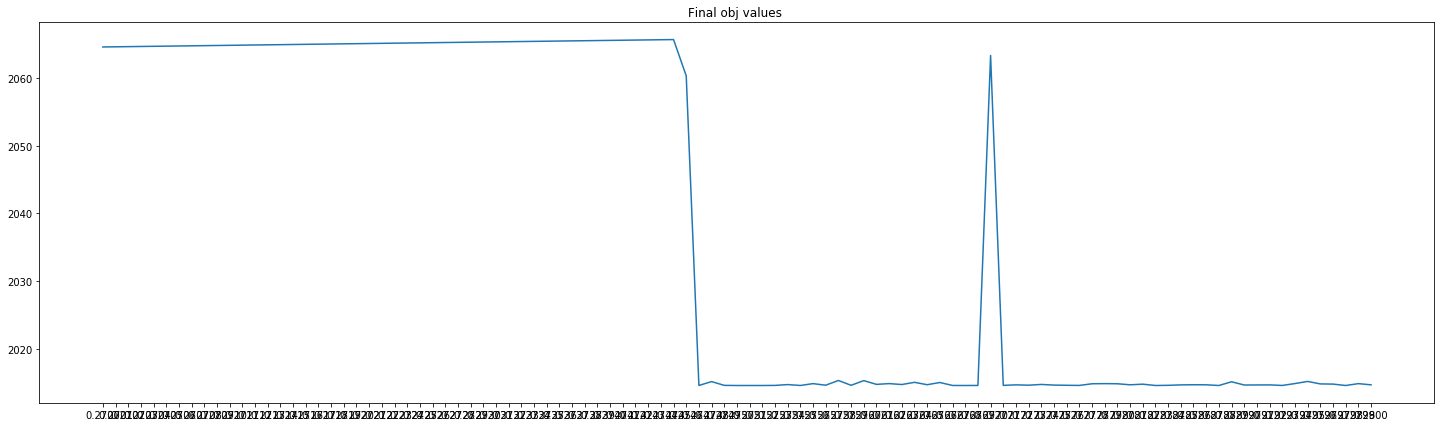

In [233]:
plt.figure(figsize=(25,7))
plt.title("Final obj values ")
plt.xticks(lambda_es)
plt.plot(lambda_es, obj_values_logit)
plt.savefig("obj_pc_ppca.png".format(lambda_e))

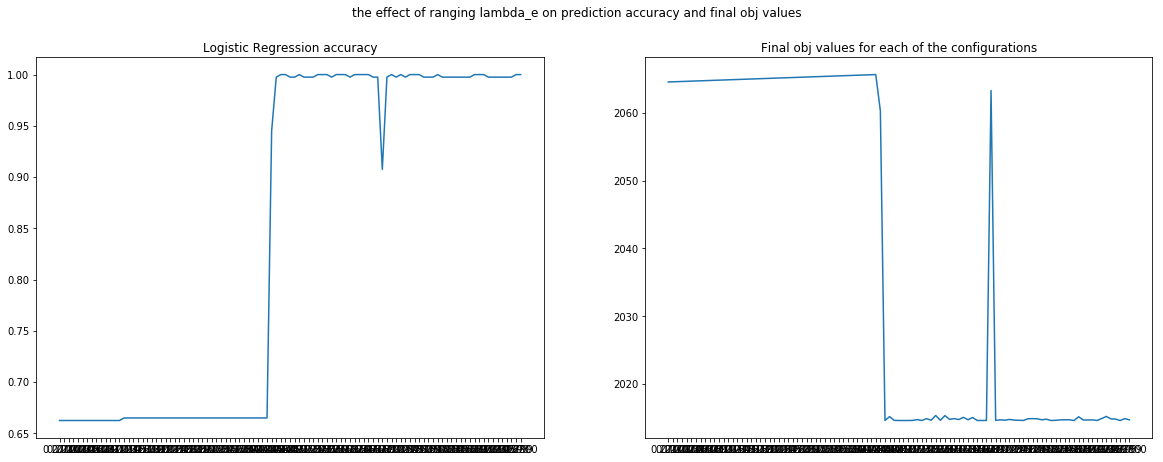

In [234]:
plt.figure(figsize=(20,7))
plt.subplot(121) 
plt.suptitle("the effect of ranging lambda_e on prediction accuracy and final obj values")
plt.title("Logistic Regression accuracy")
plt.xticks(lambda_es)
plt.plot(lambda_es, acc_scores)
plt.subplot(122) 
plt.title("Final obj values for each of the configurations")
plt.plot(lambda_es, obj_values_logit)
plt.xticks(lambda_es)
plt.show()

In [ ]:
plt.figure(figsize=(14,7))
plt.title("Logistic Regression accuracy")
plt.xticks( lambda_es)
plt.plot(lambda_es, acc_scores)
#plt.savefig("acc_pc_ppca.png".format(lambda_e))
plt.show()

In [ ]:
plt.figure(figsize=(14,7))
plt.title("LL")
plt.xticks(lambda_es)
plt.plot(lambda_es, ll_logit)
#plt.savefig("lambda_e=[0.16,0.17]_ll_pc_ppca.png".format(lambda_e))
plt.show()

In [ ]:
pred_l_logit = (-ll_logit - obj_values_logit)/lambda_es
plt.figure(figsize=(14,7))
plt.title("Prediction Likelihood")
plt.xticks(lambda_es)
plt.plot(lambda_es, pred_l_logit)
plt.savefig("pl_pc_ppca.png".format(lambda_e))